In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [53]:
#Training data

full_path = '//Users/shivapriyakrishna/Downloads/PythonExercise/Project2/drugsComTrain_raw.csv'

train_df = pd.read_csv(full_path)

print('Training data shape: ', train_df.shape)
train_df.head()


Training data shape:  (161297, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [54]:

test_full_path  = '//Users/shivapriyakrishna/Downloads/PythonExercise/Project2/drugsComTest_raw.csv'

test_df= pd.read_csv(test_full_path)

print('Testing  data shape: ', test_df.shape)
test_df.head()

Testing  data shape:  (53766, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [55]:
full_df = pd.concat([train_df, test_df], ignore_index=True)
print(f"✅ Dataset loaded successfully! Total reviews: {len(full_df):,}")

✅ Dataset loaded successfully! Total reviews: 215,063


   """Extract Voltaren/diclofenac reviews"""
        voltaren_keywords = [
            'voltaren', 'diclofenac', 'diclofenac gel', 'voltaren gel',
            'voltaren emulgel', 'topical diclofenac'
        ]

In [56]:
import re


def clean_text(text):
        """Clean review text"""
        if pd.isna(text):
            return ""
        
        text = str(text)
        # Remove URLs and special characters
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^\w\s.,!?]', '', text)
        text = re.sub(r'\d+', '', text)  # Remove numbers
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text.lower()

In [57]:
import gensim
import nltk
from nltk.corpus import stopwords

# Download nltk stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def tokenize(text):
        tokens = gensim.utils.simple_preprocess(text, deacc=True)
        tokens = [token for token in tokens if token not in stop_words]
        return tokens



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivapriyakrishna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
# Uninstall first (clean slate)
!pip uninstall pyLDAvis -y

# Install specific version that works
!pip install pyLDAvis==3.4.1


Found existing installation: pyLDAvis 2.1.2
Uninstalling pyLDAvis-2.1.2:
  Successfully uninstalled pyLDAvis-2.1.2
  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)


In [59]:

#lemmatize
import spacy

# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    # If model not found, download it
    print("📥 Downloading spaCy English model...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load('en_core_web_sm')


def extract_aspects(text):
    """
    Extracts key aspects (side effects) from a given text using spaCy.
    """
     # Use a smaller model for faster processing
    doc = nlp(text)

    aspects = []
    for token in doc:
        if token.pos_ == "NOUN" and token.dep_ == "dobj":  # Focus on nouns with a direct object (often related to side effects)
            aspects.append(token.text)
    return aspects



def lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]


In [60]:
# Define a list of additional words to remove after lemmatization
additional_words_to_remove = ["say", "new", "days", "use", "think","tennis", "made", "soccer","put", "i", "d", "take", "get","hav", "month", "amp", "amp", "many", "time", ""] # Replace with the actual words you want to remove

# Convert the list to a set for efficient lookup
additional_words_set = set(additional_words_to_remove)

# Function to remove additional words from a list of lemmas
def remove_additional_words(lemmas_list):
    return [lemma for lemma in lemmas_list if lemma not in additional_words_set]

# Apply the function to the 'lemmas' column


In [ ]:
def clean_data(drug_df):
        """Clean and prepare the data"""
        if drug_df is None:
            return
        
        # Convert date
        drug_df['date'] = pd.to_datetime(drug_df['date'], errors='coerce')
        
        # Extract year and month for time analysis
        drug_df['year'] = drug_df['date'].dt.year
        drug_df['month'] = drug_df['date'].dt.month
        
        # Clean review text
        drug_df['clean_review'] = drug_df['review'].apply(clean_text)

        # aspect considerations
        
        drug_df['aspects'] = drug_df['clean_review'].apply(extract_aspects)
      
        # create tokens for LDA model

        drug_df['tokens'] = drug_df['clean_review'].apply(tokenize)

        #create lemmas for creating dictonory and corpus LDA model

        drug_df['lemmas'] = drug_df['tokens'].apply(lemmatize)
        drug_df['lemmas_filtered'] = drug_df['lemmas'].apply(remove_additional_words)
        
        print("✅ Data cleaning completed!")
        return drug_df

In [62]:
def plot_topic_words_fixed(lda_model, dictionary, num_topics=None, words_per_topic=8):
    """Fixed version - Visualize top words for each topic"""
    
    if num_topics is None:
        num_topics = lda_model.num_topics
    
    print("🔤 Creating fixed topic words visualization...")
    
    # Get topics with consistent formatting
    topics = lda_model.show_topics(num_topics=num_topics, 
                                  num_words=words_per_topic, 
                                  formatted=False)
    
    # Prepare data for visualization
    topic_data = []
    max_words = 0
    
    for topic_id, topic_words in topics:
        words = [word for word, weight in topic_words]
        weights = [weight for word, weight in topic_words]
        topic_data.append((topic_id, words, weights))
        max_words = max(max_words, len(words))
    
    # Create consistent arrays
    all_words = []
    all_weights = []
    
    for topic_id, words, weights in topic_data:
        # Pad with empty strings if needed to make consistent length
        if len(words) < max_words:
            words = words + [''] * (max_words - len(words))
            weights = weights + [0] * (max_words - len(weights))
        all_words.append(words)
        all_weights.append(weights)
    
    # Convert to numpy arrays with consistent shapes
    all_words = np.array(all_words)
    all_weights = np.array(all_weights)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    colors = plt.cm.Set3(np.linspace(0, 1, words_per_topic))
    
    for idx, (topic_id, words, weights) in enumerate(topic_data):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        # Filter out empty words and zero weights
        valid_indices = [i for i, word in enumerate(words) if word != '']
        valid_words = [words[i] for i in valid_indices]
        valid_weights = [weights[i] for i in valid_indices]
        
        # Create horizontal bar chart
        y_pos = np.arange(len(valid_words))
        
        bars = ax.barh(y_pos, valid_weights, color=colors[:len(valid_words)], alpha=0.7, edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(valid_words, fontsize=9)
        ax.set_xlabel('Weight')
        ax.set_title(f'Topic {topic_id}', fontweight='bold')
        
        # Add value labels
        for bar, weight in zip(bars, valid_weights):
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{weight:.3f}', ha='left', va='center', fontsize=8)
        
        ax.set_xlim(0, max(valid_weights) * 1.2)
    
    # Hide unused subplots
    for idx in range(len(topic_data), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Top Words per Topic', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('topic_words_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Topic words visualization saved!")
    
    return topic_data



In [ ]:


# Create Dictionary and Corpus
#Create a dictionary and corpus from the lemmatized tokens.

import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim


def buildldamodel(drug_df):

    # Create dictionary and corpus
    id2word = corpora.Dictionary(drug_df['lemmas_filtered'])
    texts = drug_df['lemmas_filtered']
    corpus = [id2word.doc2bow(text) for text in texts]

    #Build LDA Model
    #Build an LDA model with the specified number of topics.

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=5,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    

   

     # Usage
    visualize_lda_medical(lda_model, corpus, id2word, drug_df)
    
def visualize_lda_medical(lda_model, corpus, dictionary, df):
    """Medical-domain LDA visualization"""
    
    # 1. Interactive visualization
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.save_html(vis, 'medical_lda_visualization.html')



In [64]:
!pip install pyLDAvis==2.1.2

In [79]:
# Add numpy import at the top (if you haven't already)
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pyLDAvis
from sklearn.preprocessing import normalize
# ... other imports ...

def tfidfmodel(documents):
    # --- Create TF-IDF vectorizer ---
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=1000,
        ngram_range=(2, 2)
    )

    tfidf_matrix = vectorizer.fit_transform(documents)

    # --- FIX STARTS HERE: Identify and remove empty documents ---
    # Check which rows (documents) have a sum of zero
    doc_sums = np.asarray(tfidf_matrix.sum(axis=1)).flatten()
    
    # Create masks for keeping valid rows
    non_empty_docs_mask = doc_sums > 0
    
    # Filter the matrix, the documents list, and the document lengths list
    tfidf_matrix_filtered = tfidf_matrix[non_empty_docs_mask, :]
    documents_filtered = [doc for doc, keep in zip(documents, non_empty_docs_mask) if keep]
    
    # Update the doc_lengths using the filtered documents list
    doc_lengths = [len(doc.split()) for doc in documents_filtered]

    print(f"\n🗑️ Removed {len(documents) - len(documents_filtered)} empty documents.")
    print("📊 Filtered TF-IDF Matrix Shape:", tfidf_matrix_filtered.shape)
    # --- FIX ENDS HERE ---

    feature_names = vectorizer.get_feature_names_out()
    words = np.array(feature_names)

    # Get the vocabulary and term frequencies (use filtered matrix)
    vocab = feature_names
    term_frequency = np.asarray(tfidf_matrix_filtered.sum(axis=0)).ravel()

    # (You can keep the top words print section if you like, using the filtered matrix)
    # ...

    # now apply nmf (use filtered matrix for fit_transform)
    nmf = NMF(n_components=10, init='nndsvda', solver="cd", random_state=1)

    doc_topic_dists = nmf.fit_transform(tfidf_matrix_filtered)
    topic_term_dists = nmf.components_
    
    # Normalize the distributions
    topic_term_dists = normalize(topic_term_dists, norm='l1', axis=1)
    doc_topic_dists_normalized = normalize(doc_topic_dists, norm='l1', axis=1)

        # --- ADDED: Explicitly handle NaNs/Infs right before pyLDAvis ---
    topic_term_dists = np.nan_to_num(topic_term_dists, nan=0.0, posinf=0.0, neginf=0.0)
    doc_topic_dists_normalized = np.nan_to_num(doc_topic_dists_normalized, nan=0.0, posinf=0.0, neginf=0.0)
    term_frequency = np.nan_to_num(term_frequency, nan=0.0, posinf=0.0, neginf=0.0)
    # --- END ADDED STEP ---


    for i, topic in enumerate(topic_term_dists):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

    # visualise nmf
    pyLDAvis.enable_notebook()

    # Pass the filtered and normalized components to prepare
    pyLDAvis_data = pyLDAvis.prepare(
        topic_term_dists=topic_term_dists,
        doc_topic_dists=doc_topic_dists_normalized,
        doc_lengths=doc_lengths,
        vocab=vocab,
        term_frequency=term_frequency
    )
    
    pyLDAvis.save_html(pyLDAvis_data, 'nmf_visualization.html')




sentiment analysis and visualisation

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_scores(text):
  sid_obj = SentimentIntensityAnalyzer()
  sentiment_dict = sid_obj.polarity_scores(text)
  #print(f"Sentiment Scores: {sentiment_dict}")
  #print(f"Negative Sentiment: {sentiment_dict['neg']*100}%")
  #print(f"Neutral Sentiment: {sentiment_dict['neu']*100}%")
  #print(f"Positive Sentiment: {sentiment_dict['pos']*100}%")
     
  if sentiment_dict['compound'] >= 0.05:
     return "Positive"
  elif sentiment_dict['compound'] <= -0.05:
     return "Negative"
  else:
      return "Neutral"
                    
def getsentiment_scorescompound(text):
   score_obj = SentimentIntensityAnalyzer()
   sentiment_dict = score_obj.polarity_scores(text)
   return sentiment_dict['compound'] 



    
        # Define sentiment keywords
        positive_keywords = [
            'works', 'effective', 'relief', 'good', 'great', 'excellent', 'amazing',
            'help', 'pain', 'better', 'improve', 'relieve', 'wonderful', 'fantastic',
            'recommend', 'love', 'saved', 'life', 'miracle', 'best'
        ]
        
        negative_keywords = [
            'not work', 'no effect', 'useless', 'bad', 'terrible', 'horrible',
            'side effect', 'pain', 'burn', 'rash', 'itch', 'allergic', 'worse',
            'disappoint', 'waste', 'money', 'expensive', 'stop', 'quit'
        ]
        
        def get_sentiment_score(text):
            text_lower = str(text).lower()
            pos_score = sum(1 for word in positive_keywords if word in text_lower)
            neg_score = sum(1 for word in negative_keywords if word in text_lower)
            
            if pos_score > neg_score:
                return 'positive'
            elif neg_score > pos_score:
                return 'negative'
            else:
                return 'neutral'


In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


def analyze_sentiment(df):
        """Perform sentiment analysis using Vader"""
        if df is None:
            return

        
        df['sentiment_score_compound'] = df['clean_review'].apply(getsentiment_scorescompound)
        df['sentiment_classifiers'] = df['clean_review'].apply(sentiment_scores)
        df['aspect_score'] = df['aspects'].apply(getsentiment_scorescompound)


     
        X= df[['sentiment_score_compound','rating','aspect_score']]
        Y= df['sentiment_classifiers']

        X_train, X_holdout, Y_train, Y_holdout = train_test_split(X, Y, test_size=0.4, random_state=42)

        X_val, X_test, Y_val, Y_test = train_test_split(
            X_holdout, Y_holdout,
            test_size=0.5, # Split the holdout set 50/50 (results in 20% of original data)
            random_state=42, 
            stratify=Y_holdout
        )

        # Initialize and train the Random Forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

        # Train the model using all features
        rf_classifier.fit(X_train, Y_train)

        # predict with the model

        predictions= rf_classifier.predict(X_test)

        #predict on validate data

        y_val_pred = rf_classifier.predict(X_val)


        # calculate the performance matrics
        
        accuracy = accuracy_score(Y_test,predictions)

        print( f"accuracy score is {accuracy * 100:.2f}%  " )


        # report generation

        print("detailed report")
        print(classification_report(Y_test,predictions))

        print("confusion matrix")
        print(confusion_matrix(Y_test,predictions))

        print("F1_score :")
        print(f1_score(Y_test,predictions, average='macro'))

        print("F1_score Validate:")
        print(f1_score(Y_val,y_val_pred, average='macro'))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(' Sentiment Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Sentiment Distribution (Pie chart)
        sentiment_counts = df['sentiment_classifiers'].value_counts()
        ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, 
                     autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
        ax1.set_title('Review Sentiment Distribution')

        # 2. Rating Distribution (Bar chart)
        rating_counts = df['rating'].value_counts().sort_index()
        ax2.bar(rating_counts.index, rating_counts.values, color='skyblue', alpha=0.7)
        ax2.set_title('Star Rating Distribution')
        ax2.set_xlabel('Rating (out of 10)')
        ax2.set_ylabel('Number of Reviews')


        # 3. Print sentiment distribution

        print("\n🎭 Sentiment Analysis Results:")
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(df)) * 100
            print(f"   {sentiment.capitalize()}: {count} reviews ({percentage:.1f}%)")

Bertopic Modelling 

In [68]:
def filter_specific_drug_reviews(df,drug_keywords):
     
        
        # Create a mask for specific drug reviews
        mask = df['drugName'].str.lower().str.contains('|'.join(drug_keywords), na=False)
       
        drug_df = df[mask].copy()
        print(f"🎯 Found {len(drug_df)} Voltaren/diclofenac reviews")
        if len(drug_df) > 0:
            # Basic stats
            unique_drugs = drug_df['drugName'].value_counts()
            print(f"💊 Voltaren products found:")
            for drug, count in unique_drugs.items():
                print(f"   - {drug}: {count} reviews")
        
        cleaned_df=clean_data(drug_df)     
        analyze_sentiment(cleaned_df)   
        buildldamodel(cleaned_df)      
        
        return len(drug_df) > 0

🎯 Found 920 Voltaren/diclofenac reviews
💊 Voltaren products found:
   - Diclofenac: 617 reviews
   - Voltaren Gel: 144 reviews
   - Voltaren: 113 reviews
   - Diclofenac / misoprostol: 42 reviews
   - Voltaren-XR: 4 reviews
Aspects: 287                                             [woozy]
538                                                  []
927                                  [ligament, relief]
933       [perfume, money, times, headache, ingredient]
1000                              [gel, headaches, gel]
                              ...                      
214399                                        [wonders]
214784                      [relief, relief, oxycontin]
214888                         [osteoarthritis, soccer]
214916                                 [relief, tunnel]
215006                                 [swelling, drug]
Name: aspects, Length: 920, dtype: object
✅ Data cleaning completed!
accuracy score is 99.46%  
detailed report
              precision    recall  f1-s

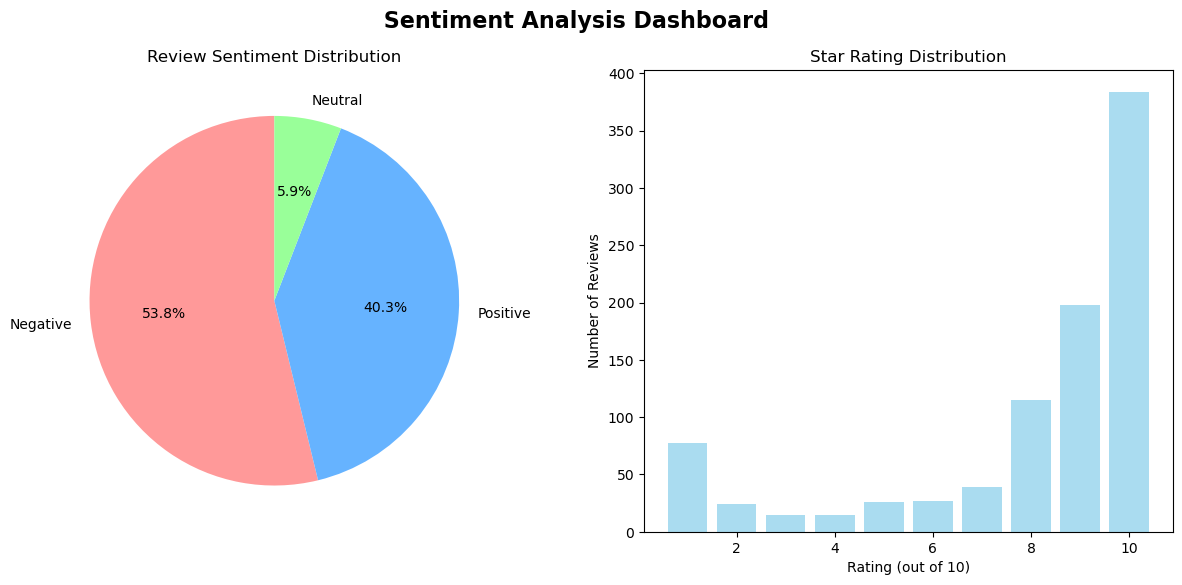

In [69]:
voltaren_keywords = [
            'voltaren', 'diclofenac', 'diclofenac gel', 'voltaren gel',
            'voltaren emulgel', 'topical diclofenac'
        ]
filter_specific_drug_reviews(full_df,voltaren_keywords);

sentiment Analysis 

In [70]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 11.5+ MB


Topic clustering and visualisation  with bertTopic

 """Set up BERTopic with optimized parameters for medical reviews"""

vader sentiment analyser

Analysis for other medicine

🎯 Found 920 Voltaren/diclofenac reviews
💊 Voltaren products found:
   - Diclofenac: 617 reviews
   - Voltaren Gel: 144 reviews
   - Voltaren: 113 reviews
   - Diclofenac / misoprostol: 42 reviews
   - Voltaren-XR: 4 reviews
Aspects: 287                                             [woozy]
538                                                  []
927                                  [ligament, relief]
933       [perfume, money, times, headache, ingredient]
1000                              [gel, headaches, gel]
                              ...                      
214399                                        [wonders]
214784                      [relief, relief, oxycontin]
214888                         [osteoarthritis, soccer]
214916                                 [relief, tunnel]
215006                                 [swelling, drug]
Name: aspects, Length: 920, dtype: object
✅ Data cleaning completed!
accuracy score is 99.46%  
detailed report
              precision    recall  f1-s

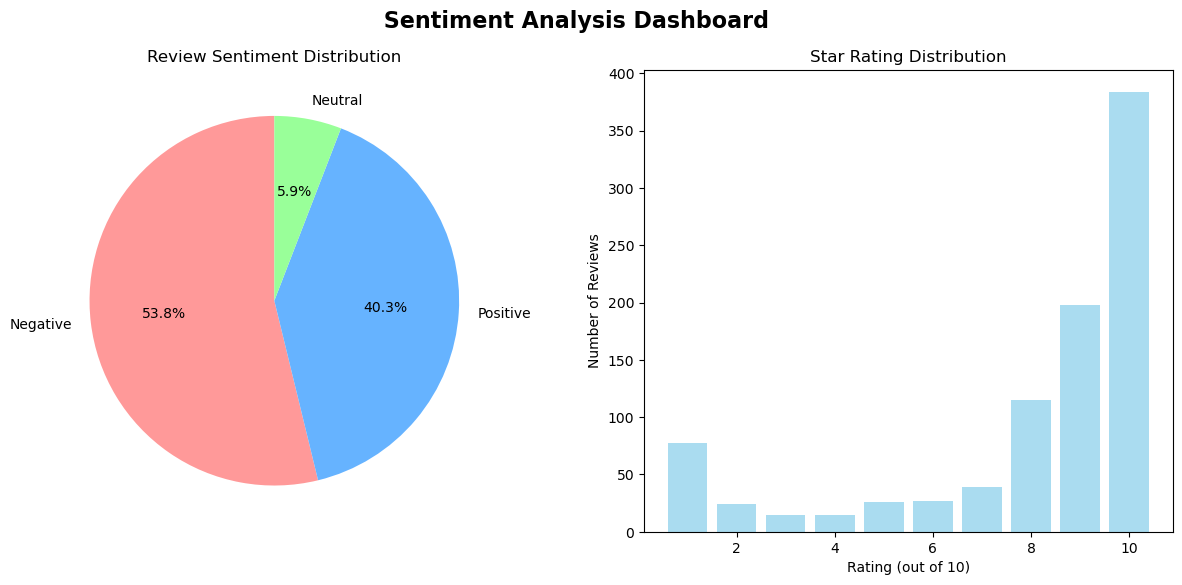

In [71]:


drug_keywords = [  'voltaren', 'diclofenac', 'diclofenac gel', 'voltaren gel',
            'voltaren emulgel', 'topical diclofenac'
        ]
filter_specific_drug_reviews(full_df,drug_keywords);

In [81]:
def filter_tfidfmodelspecific_drug_reviews(df,drug_keywords):
        
        # Create a mask for specific drug reviews
        mask = df['drugName'].str.lower().str.contains('|'.join(drug_keywords), na=False)
       
        drug_df = df[mask].copy()
        cleaned_df=clean_data(drug_df)    
        cleaned_df['review_sentiment']=cleaned_df['clean_review'].apply(sentiment_scores) 

        # for positive reviews
        review_sentimentmask= cleaned_df['review_sentiment'].str.lower().str.contains('positive')
        drugsentiment_df = cleaned_df[review_sentimentmask].copy()
        tfidfmodel(drugsentiment_df['clean_review'])      

        # for negative reviews

        review_sentimentmask= cleaned_df['review_sentiment'].str.lower().str.contains('negative')
        drugsentimentnegative_df = cleaned_df[review_sentimentmask].copy()
        tfidfmodel(drugsentimentnegative_df['clean_review'])   
        
        return len(drug_df) > 0

In [82]:
voltaren_keywords = [
            'mirtazapine'
        ]
filter_tfidfmodelspecific_drug_reviews(full_df,voltaren_keywords);

Aspects: 107                                               [anxiety]
324       [citalopram, effects, mirtazapine, sleep, life...
375           [medicine, lots, lbs, legs, insomnia, prozac]
431       [cons, sleep, weight, pounds, appetite, sweets...
990                               [insomnia, birthday, day]
                                ...                        
211763        [night, lexapro, remeron, munchies, hangover]
212023    [mirtazepine, lot, dreams, shakes, mirtazepine...
212737    [reaction, lesions, mirtazapine, pill, system,...
214229                                               [mood]
214518                [remeron, buspar, family, depression]
Name: aspects, Length: 727, dtype: object
✅ Data cleaning completed!

🗑️ Removed 9 empty documents.
📊 Filtered TF-IDF Matrix Shape: (367, 1000)
Topic 1: sleep weight,lbs months,years great,stop taking,anxiety depression,remeron night,great sleep,gain far,taking medication,weight gain
Topic 2: helped sleep,started mg,dose mg,highl

In [ ]:
!pip install --upgrade pyLDAvis



  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
  Attempting uninstall: pyLDAvis
    Found existing installation: pyLDAvis 2.1.2
    Uninstalling pyLDAvis-2.1.2:
      Successfully uninstalled pyLDAvis-2.1.2
